# DHS Data Compression and Extraction


Load data and necessary libraries 

In [5]:
% matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import IOFunctions as iof
import os 
import pprint as pp
import pandas as pd
import cv2
import pickle
import configparser
import tempfile
import boto3

Use some of the code we used before to extract PCA compressed versions of the data.

* Load 10% resized dataset
* Examine cumulative distribution of data and determine threshold
* After determining threshold, clear noise
* After clearing noise, normalize data, excluding the background.

In [14]:
#Load the data
pickle_name = 'prelim_dataset.pickle'
with open(pickle_name,"rb") as f:
    save = pickle.load(f)
    training_features = save['features']
    training_labels = save['labels']
print("Shape of features: {}".format(training_features.shape))
print("Shape of labels: {}".format(training_labels.shape))

Shape of features: (124, 300, 300, 8)
Shape of labels: (124, 17)


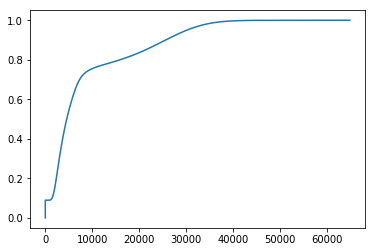

In [48]:
#Use 10% of the (resized) code to estimate the noice reducing threshold
def getCumSum(x):
    x_flat = np.sort(x,axis=None)
    n = len(x_flat)
    perc = [i/n for i in np.arange(1,n+1)]
    return x_flat,perc

x, p = getCumSum(training_features)
plt.plot(x,p)  
#Standard distribution
sns.distplot(x)
del x,p

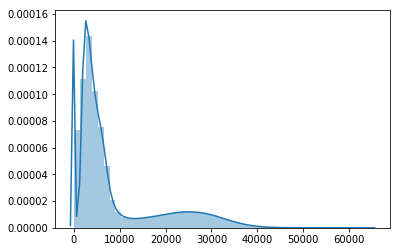

In [6]:
#Now, let's apply these duntions to the entire dataset and plot the distribution again.
#We want to normalize over the entire dataset, so that we may be able to handle duds, or samples with no subject in them.
NOISE_THRESHOLD = 7000
def NormalizeImage(x,average,std):
    return (x-average)/std

def ExtractNormParameters(x):
    mask = x > NOISE_THRESHOLD
    average = np.average(x,weights = mask)
    std = x[mask].std()
    return average,std

def ReduceNoise(x):
    if x < NOISE_THRESHOLD:
        x = NOISE_THRESHOLD
    return x

def ReduceNoiseandNormalize(x,average,std):
    for s in range(x.shape[0]):
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                for a in range(x.shape[3]):
                    x[s,i,j,a] = (ReduceNoise(x[s,i,j,a])-average)/std

def CleanData(x):
    ReduceNoise_v = np.vectorize(ReduceNoise)
    average, std = ExtractNormParameters(x)
    for s in range(x.shape[0]):
        for a in range(x.shape[3]):
            x[s,:,:,a] = ReduceNoise_v(x[s,:,:,a])
            x[s,:,:,a] = NormalizeImage(x[s,:,:,a],average,std)
    return average, std


Reduce noise and normalize before PCA.

The parameters used were an average of 20212.10523040469 and std of 9261.439914808247


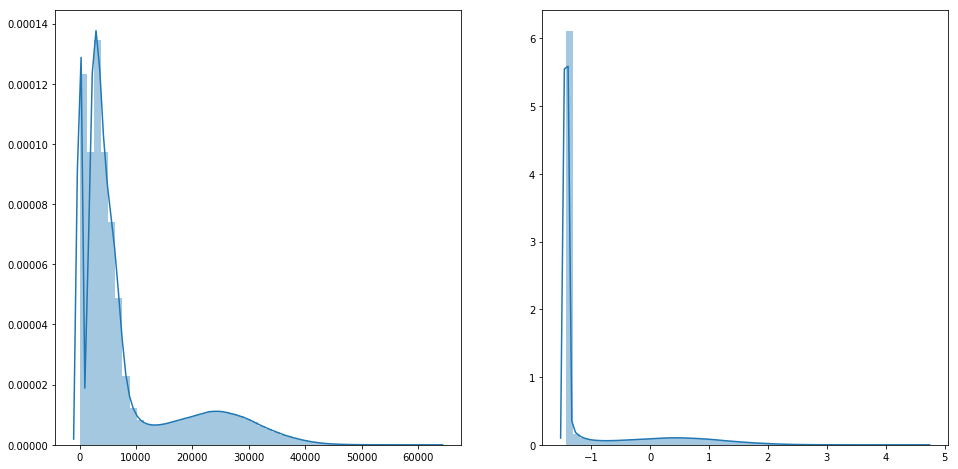

In [15]:
#Clean data, visualizing distributions before and after
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

np.random.seed(seed=0)
#Visualize 10 random samples
samples = np.random.randint(0,training_features.shape[0],20)
sns.distplot(training_features[samples,:,:,:].flatten(),ax=ax)

average, std = CleanData(training_features)
sns.distplot(training_features[samples,:,:,:].flatten(),ax=ax2)

print("The parameters used were an average of {} and std of {}".format(average,std))

del training_features, training_labels

Now that we have established a preprocessing scheme for the data, we can apply this scheme iteratively to batches of the data before fitting them using incremental PCA. 

In [10]:
with open('stats.pickle',"wb") as f:
    save = {'average':average,'std':std}
    pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
    f.close


In [7]:

#Helper functions
def GetShuffledKeys(bucket):
    contents = [k.key for k in bucket.objects.all()]
    contents = contents[1:]
    np.random.shuffle(contents) #Remove initial empty key in the result set
    return contents

def GetAWSCredentials():
    '''
    Get AWS credentials from config file.
    
    '''
    config = configparser.ConfigParser()
    config.read('S3.conf')
    AWS_ACCESS_KEY_ID = config['DEFAULT']['AccessKeyId']
    AWS_SECRET_ACCESS_KEY = config['DEFAULT']['AccessKeySecret']
    return AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY

def GetAWSClient(key_id,secret_access_key):
    '''
    Connect to S3 client. 
    
    '''
    client = boto3.resource('s3',aws_access_key_id = key_id ,
                      aws_secret_access_key= secret_access_key)
    return client
    
def GetLabelsDict(labels_dir):
    '''
    Reads csv with label data and organizes it into a dict with the image id's as keys
    and arrays of probabilities for the different zones as values.
    
    '''
    labels = pd.read_csv(labels_dir)
    labels = [[i,j] for i,j in zip(labels['Id'],labels['Probability'])] 
    labels_merged = iof.merge_17(labels) #Returns list of ids and corresponding list of zones
    labels_dict = {i:j for i,j in labels_merged}
    return labels_dict


        



class BatchRequester:
    '''
    Class used to request batches from AWS server.
    
    '''
    keys = None
    num_retrievals = 0
    key_pointer = 0
    batch_size = None
    bucket = None
    temp = None
    labels_dict = None
    extension = None
    zones = 0
    dim = []
    no_label_ary =[]
    failed_ary = []
    
    class CustomException(Exception):
        '''
        Custom Exception class
    
        '''
        def __init__(self, value):
            self.parameter = value
        def __str__(self):
            return repr(self.parameter)
    
    def __init__(self,bucket,key_ary,labels_dict,dataDir,
                 temp_dir,extension,batch_size=10,zones=17,dim=[512,660,64]):
        self.bucket = bucket
        self.keys = key_ary.copy()
        self.batch_size = batch_size
        self.temp_dir = temp_dir
        self.labels_dict = labels_dict.copy()
        self.dataDir = dataDir
        self.extension = extension    
        self.zones = zones
        self.dim = dim
    
    def DoItemsRemain(self):
        '''
        Checks to see whether any unexamined keys remain.
        
        '''
        if self.key_pointer < len(self.keys):
            return True
        else:
            return False
    
    def AttemptLabelRetrieval(self,key):
        '''
        Attempts to retrieve label data using key from dictinary passed to 
        the BatchRequester
        
        '''
        
        img_id = key.strip().replace(self.dataDir,'').replace(self.extension,'')
        try:
            label = np.array(self.labels_dict[img_id])
        except(KeyError):
            print("{} is not in the labeled data!".format(img_id))
            self.no_label_ary.append(img_id)
            raise self.CustomException("Label not found!")
        return label
        
    def AttemptDataRetrieval(self,key):
        '''
        Attempts to retrieve data from specified bucket using key.
        
        '''
        #DataException = self.CustomException("Failed data retrieval!")
        
        img_id = key.strip().replace(self.dataDir,'').replace(self.extension,'')
        filename = "{}.{}".format(img_id,self.extension)
        path = os.path.join(self.temp_dir,filename)
        failure = False
        with open(path,"w+b") as f:
            self.bucket.download_fileobj(key,f)
            try:
                img_array = iof.read_data(path)
            except:
                print("Something went wrong. Skipping {}".format(img_id))
                self.failed_ary.append(img_id)
                failure = True
        os.remove(path)
        if failure:
            raise self.CustomException("Data could ot be retrieved.")
        else:
            return img_array
    def NextBatch(self,size=None):
        '''
        Gets a batch of data of the specified size.  If no more images remain,
        then it returns a batch of smaller size.
        
        '''
        #angles = [0,8,16,24,32,40,48,56]
        #new_dim = 500
        #new_dim2 = 600
        
        if not self.DoItemsRemain():
            return None,None
        
        if not size:
            size = self.batch_size     
        
        i = 0
        batch_data = np.zeros((size,self.dim[0],self.dim[1],self.dim[2]))
        #batch_data = np.zeros((size,new_dim,new_dim2,self.dim[2]))
        batch_labels = np.zeros((size,self.zones))
        
        while i < size and self.DoItemsRemain():
            try:
                batch_labels[i,:] = self.AttemptLabelRetrieval(self.keys[self.key_pointer])
            except(self.CustomException):
                self.key_pointer += 1
                continue
            try:
                batch_data[i,:,:,:] = self.AttemptDataRetrieval(self.keys[self.key_pointer])
                #batch_data[i,:,:,:] = cv2.resize(self.AttemptDataRetrieval(self.keys[self.key_pointer]),
                 #                                dsize=(new_dim2,new_dim))
            except(self.CustomException):
                self.key_pointer += 1
                continue
            i += 1
            self.key_pointer += 1
        
        if i == size:
            return batch_data, batch_labels        
        else:
            return batch_data[:i,:,:,:],batch_labels[:i]
            
 
    

In [7]:
#First fit PCA
import gc
#AWS and Directory information 
bucketName = 'miscdatastorage'
dataDir = 'DHSData/'
temp_dir = 'temp'
labels_dir = r'stage1_labels.csv'
#Connect to AWS
key_id, secret_key = GetAWSCredentials()
client = GetAWSClient(key_id,secret_key)
bucket = client.Bucket(bucketName)
#Initialize required parameters
key_ary = GetShuffledKeys(bucket)
labels_dict = GetLabelsDict(labels_dir)
extension = '.a3daps'

requester = BatchRequester(bucket,key_ary,labels_dict,dataDir,temp_dir,extension)

#Using batches of 50 images, we clean the data set using functions from above and incrementally train PCA
from sklearn.decomposition import  IncrementalPCA

pca = IncrementalPCA(n_components = 50,copy=False)
  
b = 0
while requester.DoItemsRemain():
    gc.collect()
    print("Requesting batch...")
    X, y = requester.NextBatch(100)
    print("Cleaning data...")
    ReduceNoiseandNormalize(X,average,std)
    print("Fitting PCA...")
    pca.partial_fit(X.reshape((X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])))
    print("Completed batch {}".format(b))
    b += 1


Requesting batch...
d9b6081197ee70ebcaeabc8bf7749792 is not in the labeled data!
572b2d27afbfc215f55040501a0ae8b8 is not in the labeled data!
5b900a35f3e9591914ea328cacb73dfa is not in the labeled data!
84c8eb37e1d8b6a31178fb7acde129cc is not in the labeled data!
28970155f9954bbd7d5c737b60a66b5a is not in the labeled data!
8cc399745b482846956be7307b0bd70f is not in the labeled data!
8a59e4cd0ab21f8ac3c468ab63d2bc02 is not in the labeled data!
80f5b34aa8c962cc30138bc9c70343b5 is not in the labeled data!
Something went wrong. Skipping 628cfb55389acec85fffdfc520f3684b
Something went wrong. Skipping d5c99b34044c1cf8117a70c457a21600
Cleaning data...
Fitting PCA...
Completed batch 0
Requesting batch...
e1b48bcc8d13f1cdf8e1e98383ac5fae is not in the labeled data!
5a09d8d04a872ea04f7043bc5e0cfff8 is not in the labeled data!
47101ab882f74b44d325c4309f5a45da is not in the labeled data!
27069e6977eb7e0ccd913af254932e39 is not in the labeled data!
Something went wrong. Skipping 077c5701d8ee08e469a

Something went wrong. Skipping 07a2f948ec404e8b729541d3c2702a69
a1dab2b6bbdfec641c63b14c63eecc8f is not in the labeled data!
54becfebc071bf769a187bd50981f186 is not in the labeled data!
6efc41a030bd27eb70407184e427b165 is not in the labeled data!
c25859785ce48c8c8d7e1b4e19a6617b is not in the labeled data!
Something went wrong. Skipping 2f5c066720d997f33453dc491141bc70
8266fe33ef4df80aa66ff25bb0713c64 is not in the labeled data!
Something went wrong. Skipping e63ff6ab8dad2270d3ee2fa5b50ff24f
53c9d8c270112c05d9906e4b492c067a is not in the labeled data!
104e284349ffe68378745fc8c5638eab is not in the labeled data!
Something went wrong. Skipping 5555123a4ad6d5e4c856b5ec08035c55
Something went wrong. Skipping c39ddfd0a16b20f0f9bfef16b50feaa5
249092cc1775fabcb79ba439ba974759 is not in the labeled data!
58d8d053c3b4585d4462f5ecb1452cdb is not in the labeled data!
Cleaning data...
Fitting PCA...
Completed batch 10
Requesting batch...
77e6f30d7fb024b57861075d9cdb2e61 is not in the labeled data!

In [8]:
pca_pickle = 'pca_50.pickle'
with open(pca_pickle,"wb") as f:
    pickle.dump(pca,f,pickle.HIGHEST_PROTOCOLIGHEST_PROTOCOL)
    f.close()
print("Saved trained pca")

Saved trained pca


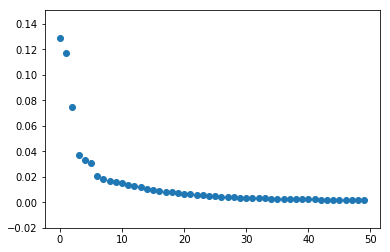

In [9]:
Examine the explained variance ratio.

index = np.arange(0,len(pca.C))
df = pd.DataFrame({'n_Component':index,'Explained_Variance_Ratio':pca.explained_variance_ratio_})
plt.scatter(df['n_Component'],df['Explained_Variance_Ratio'])


In [10]:
sum(df['Explained_Variance_Ratio'])

0.69877442740725948

In [5]:
#Visualize reconstructed data
with open('pca_50.pickle',"rb") as f:
    pca2 = pickle.load(f)
    
    
#AWS and Directory information 
bucketName = 'miscdatastorage'
dataDir = 'DHSData/'
temp_dir = 'temp'
labels_dir = r'stage1_labels.csv'
#Connect to AWS
key_id, secret_key = GetAWSCredentials()
client = GetAWSClient(key_id,secret_key)
bucket = client.Bucket(bucketName)
#Initialize required parameters
key_ary = GetShuffledKeys(bucket)
labels_dict = GetLabelsDict(labels_dir)
extension = '.a3daps'

requester = BatchRequester(bucket,key_ary,labels_dict,dataDir,temp_dir,extension)

with open('stats.pickle',"rb") as f:
    stats = pickle.load(f)
    average = stats['average']
    std = stats['std']

print("Requesting batch...")
X, y = requester.NextBatch(2)
print("Cleaning data...")
ReduceNoiseandNormalize(X,average,std)
print("Fitting PCA...")
X_transformed = pca2.transform(X.reshape((X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])))
X_recovered = pca2.inverse_transform(X_transformed).reshape((X.shape[0],X.shape[1],X.shape[2],X.shape[3]))


Requesting batch...
Cleaning data...
Fitting PCA...


ValueError: operands could not be broadcast together with shapes (2,21626880) (1280000,) 

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


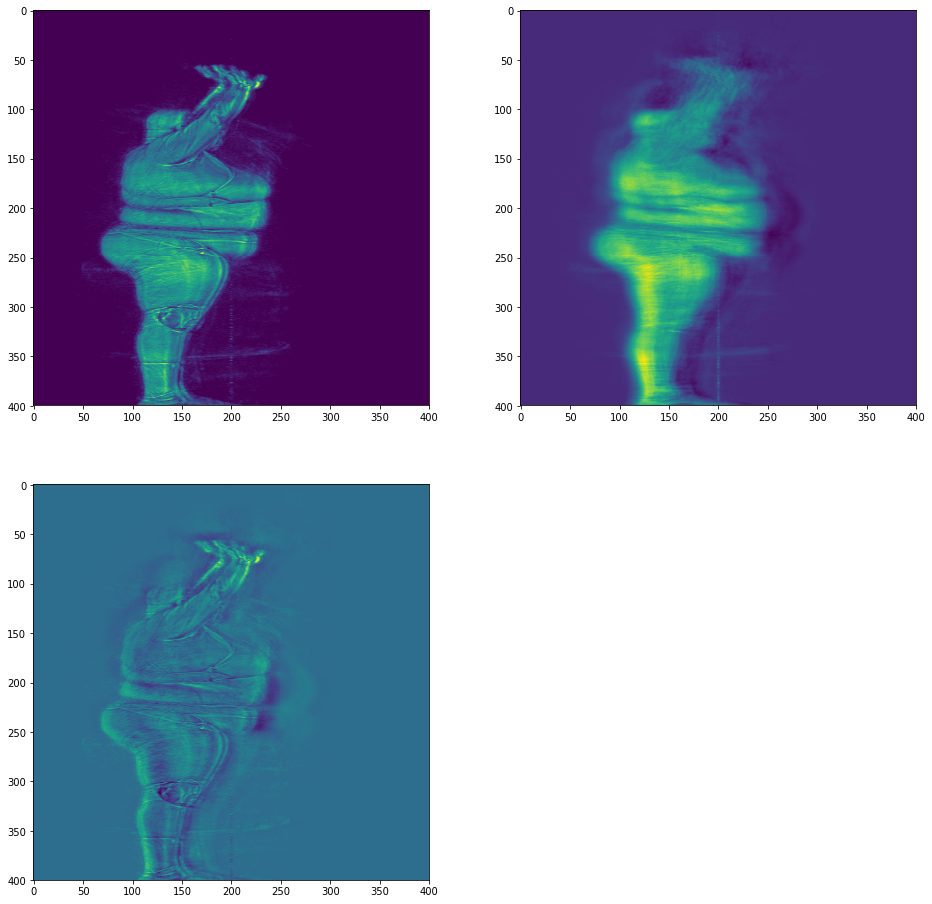

In [47]:
sample_num = 1
angle =6
print(y)
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax2.imshow(np.flipud(X_recovered[sample_num,:,:,angle].transpose()), cmap = 'viridis')
ax.imshow(np.flipud(X[sample_num,:,:,angle].transpose()), cmap = 'viridis')
X_mixed = X-X_recovered
ax3.imshow(np.flipud(X_mixed[sample_num,:,:,angle].transpose()), cmap = 'viridis')

Create train and test sets.

In [59]:
#Visualize angles and decide how to split them up to increase number of samples

requester = BatchRequester(bucket,key_ary,labels_dict,dataDir,temp_dir,extension)

X, y = requester.NextBatch(5)



[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


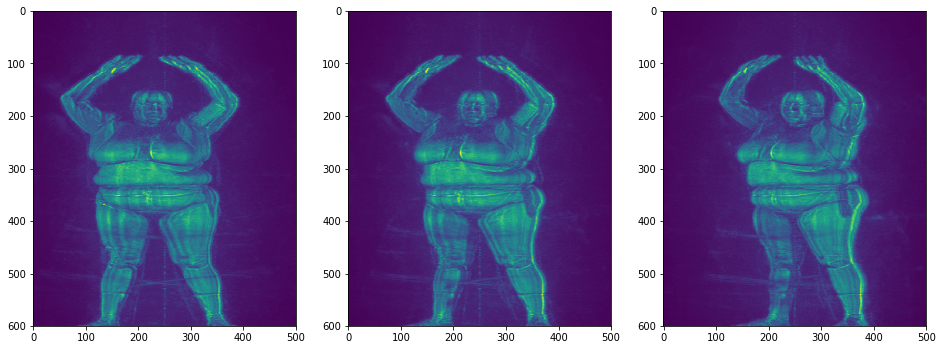

In [66]:
#Visualize
sample_num = 1
angle =15
print(y)
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax.imshow(np.flipud(X[sample_num,:,:,1].transpose()), cmap = 'viridis')
ax2.imshow(np.flipud(X[sample_num,:,:,4].transpose()), cmap = 'viridis')
ax3.imshow(np.flipud(X[sample_num,:,:,7].transpose()), cmap = 'viridis')


In [ ]:
#Create one feature with 64 angles and make each angle a different sample
#Clean data and store
#Can't store, file size too large, we're going to have to do everything out of core
import gc, gzip
from sklearn.externals import joblib

to_directory = 'DHSData_clean/'
#AWS and Directory information 
bucketName = 'miscdatastorage'
dataDir = 'DHSData/'
temp_dir = 'temp'
labels_dir = r'stage1_labels.csv'
#Connect to AWS
key_id, secret_key = GetAWSCredentials()
client = GetAWSClient(key_id,secret_key)
bucket = client.Bucket(bucketName)
#Initialize required parameters
key_ary = GetShuffledKeys(bucket)
labels_dict = GetLabelsDict(labels_dir)
extension = '.a3daps'

requester = BatchRequester(bucket,key_ary,labels_dict,dataDir,temp_dir,extension)

with open('stats.pickle',"rb") as f:
    stats = pickle.load(f)
    average = stats['average']
    std = stats['std']

b = 0
while requester.DoItemsRemain():
    gc.collect()
    print("Requesting batch...")
    X, y = requester.NextBatch(10)
    print("Cleaning data...")
    ReduceNoiseandNormalize(X,average,std)
    temp_file = os.path.join(temp_dir,"batch{}.npz".format(b))
    with open(temp_file,"wb") as f:
        #save = {'X':X,'y':y}
        print("dumping...")
        np.savez_compressed(f,X,y)
    print("Uploading...")
    #client(Key='{}batch{}.pickle'.format(to_directory,b),Body=f)
    client.meta.client.upload_file(temp_file, bucketName, 
                                   Key='{}batch{}.npz'.format(to_directory,b))
    print("Completed batch {}".format(b))
    os.remove(temp_file)
    b += 1


Requesting batch...
5ac9b630644efda24a7888b4905e422c is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Completed batch 0
Requesting batch...
b44e79c5283d5b7aa587ac26c8f3803a is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Completed batch 1
Requesting batch...
DHSData_clean/batch9.npz is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Completed batch 2
Requesting batch...
Cleaning data...
dumping...
Uploading...
Completed batch 3
Requesting batch...
Cleaning data...
dumping...
Uploading...
Completed batch 4
Requesting batch...
DHSData_clean/batch5.npz is not in the labeled data!
5ad549b6c14ae5528a56216360e87829 is not in the labeled data!
DHSData_clean/batch2.npz is not in the labeled data!
DHSData_clean/batch24.npz is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Completed batch 5
Requesting batch...
8ae7925ff082e37b2b705071dae57db8 is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Complete

Something went wrong. Skipping e06b9551603d329dfe720f67e37ce87b
Cleaning data...
dumping...
Uploading...
Completed batch 43
Requesting batch...
Something went wrong. Skipping 2c88b957986303deea705b852729b52b
Cleaning data...
dumping...
Uploading...
Completed batch 44
Requesting batch...
Something went wrong. Skipping 7ff5d172bc3ffdb931a1bf72ad118da9
366b47c7a8ccab2cd0e5834dde998765 is not in the labeled data!
DHSData_clean/batch38.npz is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Completed batch 45
Requesting batch...
76187ea862405caf22ce4626a0865d7e is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Completed batch 46
Requesting batch...
DHSData_clean/batch22.npz is not in the labeled data!
Cleaning data...
dumping...
Uploading...
Completed batch 47
Requesting batch...
Cleaning data...


In [6]:
import gc, gzip, _pickle as cPickle
to_directory = 'DHSData_clean/'
b=0
temp_file = os.path.join(temp_dir,"batch{}.pickle".format(b))
client.meta.client.upload_file(temp_file, bucketName, 
                                   Key='{}batch{}.pickle'.format(to_directory,b))

In [ ]:
#We might potentially be able to increase the number of samples if we discretize angles, 
#make it an extra feature and use images from the angles within the range as extra samples
#There is dimensionality reduction inherent in deep learning, so let's try a neural net now. 
from sklearn.neural_network import MLPClassifier

clf = MLP((100,100),early_stopping = True)

requester = BatchRequester(bucket,key_ary,labels_dict,dataDir,temp_dir,extension)

b = 0
while requester.DoItemsRemain():
    gc.collect()
    print("Requesting batch...")
    X, y = requester.NextBatch(100)
    print("Cleaning data...")
    ReduceNoiseandNormalize(X,average,std)
    print("Fitting PCA...")
    pca.partial_fit(X.reshape((X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])))
    print("Completed batch {}".format(b))
    b += 1


In [9]:
#Divide the data into train, test 
from sklearn.model_selection import train_test_split
training_features_rs = np.reshape(training_features,(training_features.shape[0],
                                             training_features.shape[1]*training_features.shape[2]*training_features.shape[3]))
X_train,X_test,y_train,y_test = train_test_split(training_features_rs,training_labels,random_state=0,train_size=0.80)
del training_features_rs #Prevent memory issues

/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
